# Contents  

1. The general python environment  
2. Read in the data 
3. Set up the pipeline  
4. Define and run the neural network
5. Produce some basic outputs 

# 1.	The general Python environment

In [7]:
!pip show torch pandas numpy scikit-learn torch

Name: torch
Version: 1.11.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /Users/anaconda3/lib/python3.9/site-packages
Requires: typing_extensions
Required-by: torchvision, torchaudio, fastai
---
Name: pandas
Version: 1.3.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /Users/anaconda3/lib/python3.9/site-packages
Requires: python-dateutil, pytz, numpy
Required-by: statsmodels, seaborn, fastai
---
Name: numpy
Version: 1.20.3
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /Users/anaconda3/lib/python3.9/site-packages
Requires: 
Required-

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from torch.utils.data.sampler import BatchSampler, RandomSampler
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.autograd import Variable

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
import math

Set the number of epochs to run

In [9]:
nn_iter = 1000     

pd.options.display.float_format = '{:,.2f}'.format

# 2. Read in the data  

This dataset has the train and test data splits pre-defined by the train_ind flag.

In [12]:
dirname_in="https://raw.githubusercontent.com/MLRWP/mlrwp-book/main/Research/"
filename_in="datwTestTrainSplit.csv"

dat = pd.read_csv(
    dirname_in + filename_in
)

# 3. Set up the pipeline - define the classes to be used  

* Define the TabularNetRegressor class
* Define the ColumnKeeper class

### Define the TabularNetRegressor class

In [13]:
class TabularNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        module,
        criterion=nn.MSELoss(),
        max_iter=nn_iter,   
        max_lr=0.01,
        keep_best_model=False,
        batch_function=None,
        rebatch_every_iter=1,
        n_hidden=20,                  
        l1_penalty=0.0,          # lambda is a reserved word
        l1_applies_params=["linear.weight", "hidden.weight"],
        weight_decay=0.0,
        batch_norm=False,
        dropout=0.0,
        clip_value=None,
        verbose=1,                
        device="cpu", #if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),  # Use GPU if available, leave mps off until more stable
        init_bias=None,
        **kwargs
    ):
 
        self.module = module
        self.criterion = criterion
        self.keep_best_model = keep_best_model
        self.l1_penalty = l1_penalty
        self.l1_applies_params = l1_applies_params
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.n_hidden = n_hidden
        self.batch_norm = batch_norm
        self.batch_function = batch_function
        self.rebatch_every_iter = rebatch_every_iter
        self.dropout = dropout
        self.device = device
        self.target_device = torch.device(device)    
        self.max_lr = max_lr
        self.init_bias = init_bias
        self.print_loss_every_iter = max(1, int(max_iter / 10))
        self.verbose = verbose
        self.clip_value = clip_value
        self.kwargs = kwargs

        
    def fix_array(self, y):
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        y = y.astype(np.float32)
        return y
        

    def setup_module(self, n_input, n_output):
        self.module_ = self.module(
            n_input=n_input, 
            n_output=n_output,
            n_hidden=self.n_hidden,
            batch_norm=self.batch_norm,
            dropout=self.dropout,
            init_bias=self.init_bias_calc if self.init_bias is None else self.init_bias,
            **self.kwargs
        ).to(self.target_device)
        

    def fit(self, X, y):
        # The main fit logic is in partial_fit
        # We will try a few times if numbers explode because NN's are finicky and we are doing CV
        n_input = X.shape[-1]
        n_output = 1 if y.ndim == 1 else y.shape[-1]
        self.init_bias_calc = np.log(y.mean()).values.astype(np.float32)
        self.setup_module(n_input=n_input, n_output=n_output)

        # Partial fit means you take an existing model and keep training 
        # so the logic is basically the same
        self.partial_fit(X, y)

        return self


    def partial_fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, multi_output=True)

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(self.fix_array(X)).to(self.target_device)
        y_tensor = torch.from_numpy(self.fix_array(y)).to(self.target_device)

        # Optimizer - the generically useful AdamW. Other options like SGD
        # are also possible.
        optimizer = torch.optim.AdamW(
            params=self.module_.parameters(),
            lr=self.max_lr / 10,
            weight_decay=self.weight_decay
        )
        
        # Scheduler - one cycle LR
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.max_lr, 
            steps_per_epoch=1, 
            epochs=self.max_iter
        )

        # Loss Function
        try:
            loss_fn = self.criterion(log_input=False).to(self.target_device)  # Pytorch loss function
        except TypeError:
            loss_fn = self.criterion  # Custom loss function

        best_loss = float('inf') # set to infinity initially

        if self.batch_function is not None:
            X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        else:
            X_tensor_batch, y_tensor_batch = X_tensor, y_tensor

        # Training loop
        for epoch in range(self.max_iter):   # Repeat max_iter times

            self.module_.train()
            y_pred = self.module_(X_tensor_batch)  #  Apply current model

            loss = loss_fn(y_pred, y_tensor_batch) #  What is the loss on it?
            if self.l1_penalty > 0.0:        #  Lasso penalty
                loss += self.l1_penalty * sum(
                    [
                        w.abs().sum()
                        for p, w in self.module_.named_parameters()
                        if p in self.l1_applies_params
                    ]
                )

            if self.keep_best_model & (loss.item() < best_loss):
                best_loss = loss.item()
                self.best_model = self.module_.state_dict()

            optimizer.zero_grad()            #  Reset optimizer
            loss.backward()                  #  Apply back propagation

            # gradient norm clipping
            if self.clip_value is not None:
                grad_norm = torch.nn.utils.clip_grad_norm_(self.module_.parameters(), self.clip_value)
                # check if gradients have been clipped
                if (self.verbose >= 1) & (grad_norm > self.clip_value):
                    print(f'Gradient norms have been clipped in epoch {epoch}, value before clipping: {grad_norm}')    

            optimizer.step()                 #  Update model parameters
            scheduler.step()

            if torch.isnan(loss.data).tolist():
                raise ValueError('Error: nan loss')


            # Every self.print_loss_every_iter steps, print RMSE 
            if (epoch % self.print_loss_every_iter == 0) and (self.verbose > 0):
                self.module_.eval()                     # Eval mode 
                self.module_.point_estimates=True       # Distributional models - set to point                
                y_pred_point = self.module_(X_tensor)   # Get "real" model estimates
                assert(y_pred_point.size() == y_tensor.size())
                rmse = torch.sqrt(torch.mean(torch.square(y_pred_point - y_tensor)))
                self.module_.train()                     # back to training
                self.module_.point_estimates=False       # Distributional models - set to point
                
                print("Train RMSE: ", rmse.data.tolist(), " Train Loss: ", loss.data.tolist(), " Epoch: ", epoch)

            if (self.batch_function is not None) & (epoch % self.rebatch_every_iter == 0):
                print(f"refreshing batch on epoch {epoch}")
                X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        
        if self.keep_best_model:
            self.module_.load_state_dict(self.best_model)
            self.module_.eval()

        # Return the regressor
        return self


    def predict(self, X, point_estimates=True):
        # Checks
        check_is_fitted(self)      # Check is fit had been called
        X = check_array(X)         # Check input

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(self.fix_array(X)).to(self.target_device)
      
        self.module_.eval()  # Eval (prediction) mode
        self.module_.point_estimates = point_estimates

        # Apply current model and convert back to numpy
        if point_estimates:
            y_pred = self.module_(X_tensor).cpu().detach().numpy()
            if y_pred.shape[-1] == 1: 
                return y_pred.ravel()
            else:
                return y_pred
        else:
            y_pred = self.module_(X_tensor)
            return y_pred


    def score(self, X, y):
        # Negative RMSE score (higher needs to be better)
        y_pred = self.predict(X)
        y = self.fix_array(y)
        return -np.sqrt(np.mean((y_pred - y)**2))
    
    

### Define the ColumnKeeper class

In [14]:
class ColumnKeeper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X.copy()[self.cols]

# 4. Define and run the neural network  

* Define the LogLinkForwardNet class
* Define which variables to include in the model
* Run the model using pipeline

### Define the LogLinkForward class

In [15]:
class LogLinkForwardNet(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self, 
        n_hidden,                                          # hidden layer size
        batch_norm,                                        # whether to do batch norm (boolean) 
        dropout,                                           # dropout percentage,
        n_input=8,                                         # number of inputs
        n_output=1,                                        # number of outputs
        init_bias=0,                                     # init mean value to speed up convergence        
    ): 

        super(LogLinkForwardNet, self).__init__()

        self.hidden = torch.nn.Linear(n_input, n_hidden)   # Hidden layer
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchn = torch.nn.BatchNorm1d(n_hidden)   # Batchnorm layer
        self.dropout = nn.Dropout(dropout)

        self.linear = torch.nn.Linear(n_hidden, n_output)  # Linear coefficients

        nn.init.zeros_(self.linear.weight)                 # Initialise to zero
        # nn.init.constant_(self.linear.bias, init_bias)        
        self.linear.bias.data = torch.tensor(init_bias)

    # The forward function defines how you get y from X.
    def forward(self, x):
        h = F.relu(self.hidden(x))                         # Apply hidden layer    
        if self.batch_norm:
            h = self.batchn(h)                       # Apply batchnorm   
       
        return torch.exp(self.linear(h))                   # log(Y) = XB -> Y = exp(XB)

### Define which variables to include in the model

In [16]:
list_of_features = [
    "claim_no",
    "occurrence_time", 
    "notidel", 
    "development_period", 
    "pmt_no",
    "log1_paid_cumulative",
    "max_paid_dev_factor",
    "min_paid_dev_factor",
]
output_field = ["claim_size"]
youtput="claim_size"

dat.loc[:, list_of_features + [youtput]]
#dat.loc[:, list_of_features + output_field]

claim_no  occurrence_time  notidel  development_period  pmt_no  \
0              1             0.73     0.66                   1    0.00   
1              1             0.73     0.66                   2    0.00   
2              1             0.73     0.66                   3    0.00   
3              1             0.73     0.66                   4    0.00   
4              1             0.73     0.66                   5    1.00   
...          ...              ...      ...                 ...     ...   
142836      3663            39.87     2.29                  35    6.00   
142837      3663            39.87     2.29                  36    6.00   
142838      3663            39.87     2.29                  37    6.00   
142839      3663            39.87     2.29                  38    6.00   
142840      3663            39.87     2.29                  39    6.00   

        log1_paid_cumulative  max_paid_dev_factor  min_paid_dev_factor  \
0                       0.00                 0.00                 0.00   
1                       0.00                 0.00                 0.00   
2                       0.00                 0.00                 0.00   
3                       0.00                 0.00                 0.00   
4                       9.49                 0.00                 0.00   
...                      ...                  ...                  ...   
142836                 10.61                 4.01                 1.00   
142837                 10.61                 4.01                 1.00   
142838                 10.61                 4.01                 1.00   
142839                 10.61                 4.01                 1.00   
142840                 10.61                 4.01                 1.00   

        claim_size  
0       232,310.09  
1       232,310.09  
2       232,310.09  
3       232,310.09  
4       232,310.09  
...            ...  
142836   40,653.72  
142837   40,653.72  
142838   40,653.72  
142839   40,653.72  
142840   40,653.72  

[142841 rows x 9 columns]

### Run the model using pipeline

In [26]:
model_NN = Pipeline(
    steps=[
        ("keep", ColumnKeeper(list_of_features)),   # both
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(LogLinkForwardNet))
    ]
)

model_NN.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["claim_size"]]
)

Train RMSE:  247010.125  Train Loss:  61016887296.0  Epoch:  0
Train RMSE:  237760.8125  Train Loss:  56719429632.0  Epoch:  100
Train RMSE:  181235.75  Train Loss:  33207771136.0  Epoch:  200
Train RMSE:  134555.015625  Train Loss:  18137094144.0  Epoch:  300
Train RMSE:  128443.875  Train Loss:  16502144000.0  Epoch:  400
Train RMSE:  127169.71875  Train Loss:  16174551040.0  Epoch:  500
Train RMSE:  126544.5234375  Train Loss:  16014451712.0  Epoch:  600
Train RMSE:  126287.34375  Train Loss:  15948923904.0  Epoch:  700
Train RMSE:  126171.1875  Train Loss:  15919357952.0  Epoch:  800
Train RMSE:  126127.328125  Train Loss:  15908151296.0  Epoch:  900


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['claim_no', 'occurrence_time', 'notidel',
                                    'development_period', 'pmt_no',
                                    'log1_paid_cumulative',
                                    'max_paid_dev_factor',
                                    'min_paid_dev_factor'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 TabularNetRegressor(module=<class '__main__.LogLinkForwardNet'>))])

# 5. Produce some basic outputs  
See the Diagnostics blog for more examples of outputs

##### Plots of expected and actual ultimates by occurence period and development period (also split by train/test/total datasets)

In [27]:
# Diagnostic model subplots
# We will be repeating this logic across multiple models, so put logic into function for repeatability

#COULD PLOT MEAN OR SUM

def make_model_subplots(model, dat):
    fig, axes = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(15, 15))

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: df.train_ind]
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[0,0], logy=True)
    axes[0,0].title.set_text("Train, Occur")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: df.train_ind]
        .groupby(["development_period"])
        .agg({youtput: "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[0,1], logy=True)
    axes[0,1].title.set_text("Train, Dev")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: ~df.train_ind]
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[1,0], logy=True)
    axes[1,0].title.set_text("Test, Occ")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: ~df.train_ind]
        .groupby(["development_period"])
        .agg({youtput: "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[1,1], logy=True)
    axes[1,1].title.set_text("Test, Dev")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[2,0], logy=True)
    axes[2,0].title.set_text("All, Occ")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .groupby(["development_period"])
        .agg({youtput: "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[2,1], logy=True)
    axes[2,1].title.set_text("All, Dev")

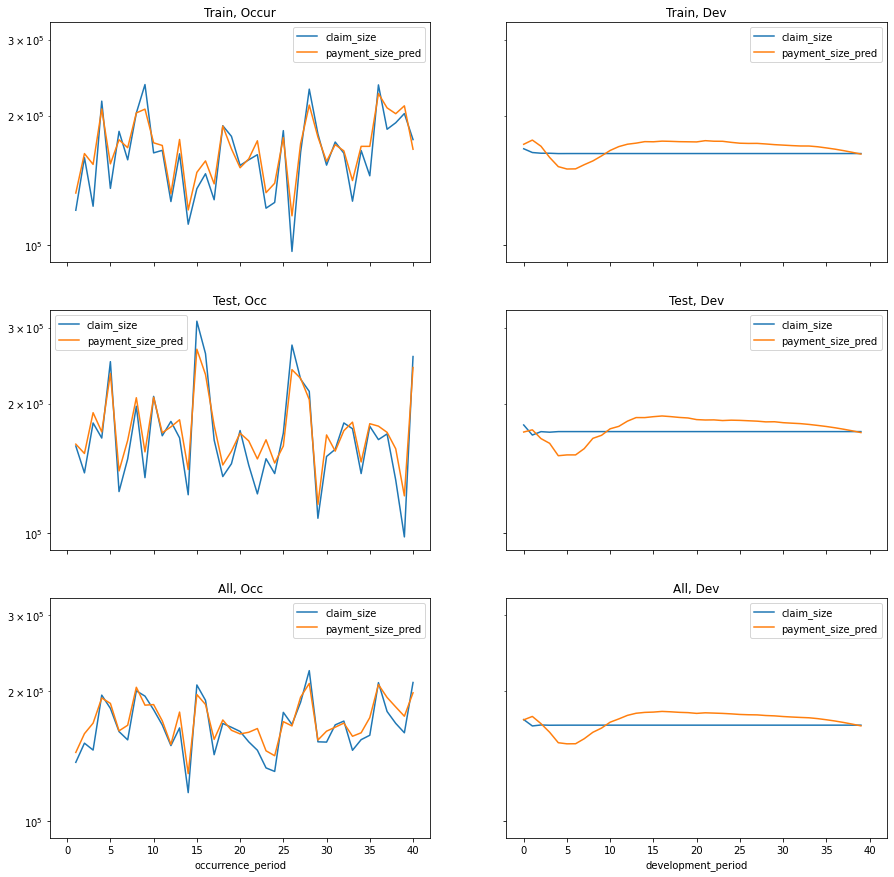

In [28]:
make_model_subplots(model_NN, dat)

In [29]:
dat["pred_claims"]=model_NN.predict(dat)

#### A vs E scatterplot

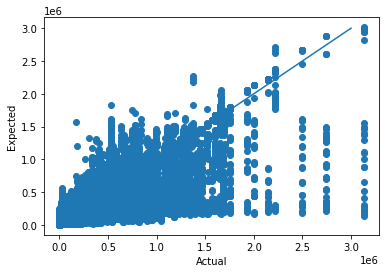

In [30]:
plt.scatter(dat[youtput], dat["pred_claims"])
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.plot([0,3000000],[0,3000000])

#### QQ plots, for training data and test data

In [31]:
dat["pred_claims_decile"] = pd.qcut(dat["pred_claims"], 10, labels=False, duplicates='drop')
dat["pred_claims_20cile"] = pd.qcut(dat["pred_claims"], 20, labels=False, duplicates='drop')

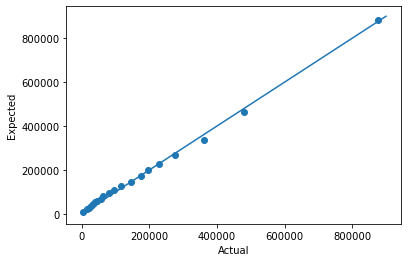

In [32]:
# Train dataset
X_sum = dat.loc[dat.train_ind == 1].groupby("pred_claims_20cile").agg("mean").reset_index()

X_sum = dat.groupby("pred_claims_20cile").agg("mean").reset_index()

plt.scatter(X_sum.claim_size, X_sum.pred_claims)
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.plot([0,900000],[0,900000])

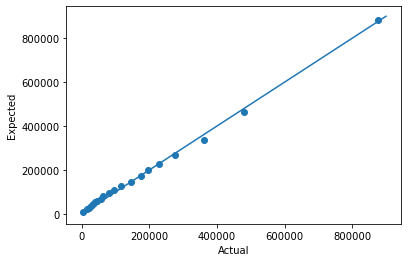

In [33]:
# Test dataset
X_sum = dat.loc[dat.train_ind == 0].groupby("pred_claims_20cile").agg("mean").reset_index()

X_sum = dat.groupby("pred_claims_20cile").agg("mean").reset_index()

plt.scatter(X_sum.claim_size, X_sum.pred_claims)
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.plot([0,900000],[0,900000])